<a href="https://colab.research.google.com/github/SaketMunda/transfer-learning-with-tensorflow/blob/master/transfer_learning_with_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow - Part 1 : Feature Extraction


If you've been thinking, "surely someone else has spent the time crafting the right model for the job..." then you're in luck.

For many of the problems, you'll want to use deep learning for, chances are, a working model already exists.

And the good news is, you can access many of them on TensorFlow Hub.

[TensorFlow Hub](https://tfhub.dev/) is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

For this notebook we will experiment the Food Vision problem that we did in [this repo](https://github.com/SaketMunda/cnn-computer-vision-introduction) but with less data, to be specific only 10% of data for training set.

Why ? **Transfer leanring often allows you to get great results with less data.**

## Problem Definition

We're working towards building, taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset of our own images.

## Downloading and becoming one with the data

In [2]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-12-09 06:58:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.6MB/s    in 4.7s    

2022-12-09 06:58:25 (34.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images we have in each folder ?

import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza

Notice how each of the training directories now has 75 images rather than 750 images. This is the key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

## Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the `ImageDateGenerator` class along with the `flow_from_directory` method to load in our images.

In [4]:
# Setup the data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

# Initiating ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (thing to run whilst training our model)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model experiments.

And that concept is **callbacks**.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

- [Experiment tracking with TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard)(a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
- [Model Checkpoints](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
- [Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.


The Tensorboard callback can be accessed using `tf.keras.callbacks.TensorBoard()`.

It's main functionality is saving a model's training performance metrics to a specified `log_dir`.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

> **Note**: We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance(so the function will create a new one each time it's run).


In [5]:
# CReate tensorboard callback (functionized because need to create a new one for each model)
import datetime
import tensorflow
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Because we're going to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function save a model's performace logs to a directory named,
`[dir_name]/[experiment_name]/[current_timestamp]`


## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from `TensorFlow Hub`.

In fact, we're going to use two models from TensorFlow Hub:
* [ResNet50V2](https://arxiv.org/abs/1603.05027) : a state of art computer vision model architecture from 2016
* [EfficientNetB0](https://arxiv.org/abs/1905.11946) : a state of art computer vision model architecture from 2019

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

We can see a list of state of the art models on [paperwithcode.com](https://www.paperswithcode.com/), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since, we're working with images, our target are the [models which performs best on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet).

Let's build our model using the above said models from TensorFlow Hub.

First we'll import TensorFlow and TensorFlow Hub.

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Now we'll get feature vector URLs of two common computer vision architectures, [EfficientNetB0(2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) and [ResNetV250(2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4) from TensorFlow Hub

In [7]:
# Resnet50V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNetB0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the `KerasLayer()` model inside the TensorFlow Hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instantiate a Keras Sequential model with the appropriate number of output layers, compile the model and return the model.

In [8]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in output layer, should be equal
    to number of target classes, default 10.
  Returns:
    A compiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  # Download the pretrained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer, # use feature extraction layer as the base
      layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  # compile our model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer='Adam',
                metrics=['accuracy'])
  
  return model

Great ! Now we've got a function for creating a model, we'll use it to first create and compile a model using Resnet50V2 architecture as our feature extraction compiled model.

Then we'll fit the model with our own training data and test data and also use the callbacks.

In [9]:
# Create and Compile a model
resnet_model = create_model(model_url=resnet_url,
                            num_classes=train_data_10_percent.num_classes)

# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221209-065840
Epoch 1/5
24/24 [==============================] - 33s 948ms/step - loss: 2.0681 - accuracy: 0.3000 - val_loss: 1.2714 - val_accuracy: 0.5788
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.9260 - accuracy: 0.7227 - val_loss: 0.8960 - val_accuracy: 0.7064
Epoch 3/5
24/24 [==============================] - 17s 735ms/step - loss: 0.6290 - accuracy: 0.8200 - val_loss: 0.7857 - val_accuracy: 0.7404
Epoch 4/5
24/24 [==============================] - 18s 764ms/step - loss: 0.4878 - accuracy: 0.8800 - val_loss: 0.7212 - val_accuracy: 0.7580
Epoch 5/5
24/24 [==============================] - 17s 737ms/step - loss: 0.3861 - accuracy: 0.9080 - val_loss: 0.6915 - val_accuracy: 0.7700


Wow !

It seems that after only 5 epochs, the ResNet50V2 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...**with only 10 percent of the training images!**

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our `plot_loss_curves` function.

In [10]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='Training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()

  # Plot accuracy
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(); 

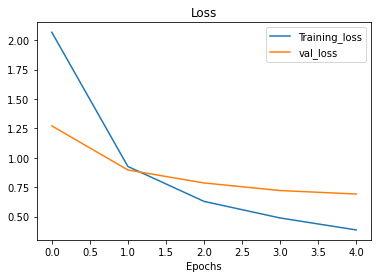

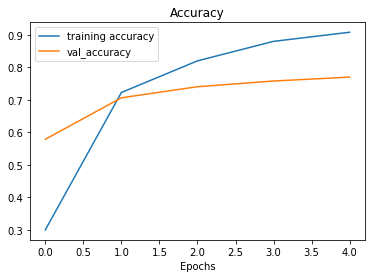

In [11]:
plot_loss_curves(resnet_history)

And what about a summary of our model ?

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,585,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset.
Since we set `trainable=False`, these patterns remain frozen(non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.


Now we've trained the Resnet50V2 model, time to do the same with EfficientNetB0 model.

In [14]:
# Create and compile model
efficientnet_model = create_model(efficientnet_url,
                                  train_data_10_percent.num_classes)

# fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[
                                                  create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                               experiment_name='efficientnetb0')
                                              ])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221209-071049
Epoch 1/5
24/24 [==============================] - 26s 726ms/step - loss: 1.8454 - accuracy: 0.4307 - val_loss: 1.2916 - val_accuracy: 0.7480
Epoch 2/5
24/24 [==============================] - 17s 716ms/step - loss: 1.0734 - accuracy: 0.7867 - val_loss: 0.8647 - val_accuracy: 0.8216
Epoch 3/5
24/24 [==============================] - 16s 667ms/step - loss: 0.7574 - accuracy: 0.8373 - val_loss: 0.6943 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 16s 670ms/step - loss: 0.6088 - accuracy: 0.8640 - val_loss: 0.6076 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.5159 - accuracy: 0.8880 - val_loss: 0.5501 - val_accuracy: 0.8628


The EfficientNetB0 model does even better than ResNet50V2 model! Achieving over 85% accuracy on the test set.. again with only 10% of the training data.

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

let's check out the loss curves.

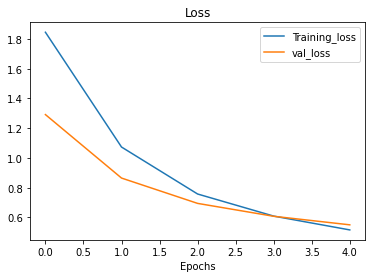

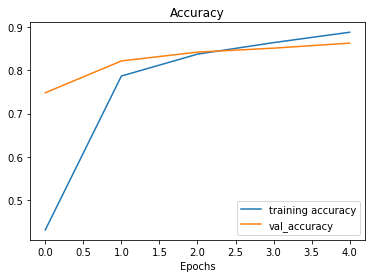

In [15]:
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training for longer, the validation accuracy will increase hence improve our model even more for our use case.

Let's check out the model summary.

In [16]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


It seems that, despite having over four times less parameters (4,049,564 vs 23,564,800) than the ResNet50V2 extraction layer, the EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the 'efficient' name came from.

## Types of Transfer Learning

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.
  - For example, many compVis models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).
    - This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it;s not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Models with `/classification` in their name on TensorFlow Hub provide this kind of functionality.
2. **"Feature Extraction" transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
  - For eg, say the pretrained model you were using had 236 different layers(EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen.**
3. **"Fine-Tuning" transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust(fine-tune) them to your own problem.
  - This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g 100+ images per class) where your data is slightly different to the data the original model was trained on.

## Comparing models using TensorBoard

Alright, event though we've already compared the performance of our two models by looking at the accuracy scores. But what if you had more than two models ?

That's where an experiment tracking tool like [TensorBoard](https://www.tensorflow.org/tensorboard) comes in.

The good thing is, since we setup a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to [TensorBoard.dev](https://tensorboard.dev/)

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompaning Colab Notebook.

### Uploading experiments to TensorBoard

To upload a series of TensorFlow logs to Tensorboard, we can use the following command:

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 Vs ResNet50V2" \
  --description "Comparing two different TF hub feature extraction models architecture using 10% of training images" \
  --one_shot # this is to exit

TensorBoard Experiment URL : https://tensorboard.dev/experiment/PFzAwQrlS1eXwkNwq3bZ4w/

In above execution code,
* `--logdir` is the target upload directory
* `--name` is the name of the experiment
* `--description` is the description
* `--one_shot` exits the TensorBoard uploader once uploading is finished

### Listing experiments you've saved to TensorBoard

To see all the experiments you've uploaded you can use the command:
`tensorboard dev list`

In [18]:
!tensorboard dev list

https://tensorboard.dev/experiment/PFzAwQrlS1eXwkNwq3bZ4w/
	Name                 EfficientNetB0 Vs ResNet50V2
	Description          Comparing two different TF hub feature extraction models architecture using 10% of training images
	Id                   PFzAwQrlS1eXwkNwq3bZ4w
	Created              2022-12-09 07:33:32 (6 minutes ago)
	Updated              2022-12-09 07:33:36 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)


### Deleting experiment from Tensorboard

Remember, all uploads to TensorBoard.dev are public, so to delete an experiment you can use the command:

`tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]`